In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import pickle
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('training_data.pkl', 'rb') as f:
    normed_data = pickle.load(f)
normed_data 

,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,...,position_z,velocity_x,velocity_y,velocity_z,UNIX_TIMESTAMP,position_magnitude,velocity_magnitude,delta_position,delta_velocity,is_anomaly
0,1.308893,0.998304,0.017784,-2.286683,-0.061179,1.628305,-1.313368,1.625107,0.104430,0.117643,...,-1.303404,-0.088689,-1.072418,1.534341,1.624880,0.040143,0.679836,0.023485,-0.025860,False
1,0.749933,0.988275,0.009075,-2.249000,-0.055091,1.615132,-1.300316,1.624860,0.108325,0.122165,...,-1.302948,-0.076692,-1.073611,1.534331,1.624634,0.054837,0.660563,0.011653,-0.015825,False
2,0.749933,0.988275,0.009075,-2.249000,-0.055091,1.615132,-1.300316,1.624860,0.108325,0.122165,...,-1.302948,-0.076692,-1.073611,1.534331,1.624634,0.054837,0.660563,0.000058,0.000021,False
3,-0.261546,0.967117,-0.110770,-1.269248,-0.046797,1.620837,-0.439995,1.624490,0.083793,0.093264,...,1.020281,1.715747,-0.056333,-0.011752,1.624297,-0.806829,-0.127143,-0.679873,-0.647652,False
4,0.513163,0.967895,-0.015806,-2.211317,-0.039848,1.598975,-1.284303,1.624244,0.123785,0.140204,...,-1.302749,-0.047266,-1.075957,1.534313,1.624017,0.081477,0.626305,0.701011,0.619527,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,-0.177872,-1.248345,0.252911,0.878671,-1.218480,-1.009489,-0.654351,-1.804242,-0.088023,-0.108821,...,0.027368,0.123324,-1.320458,-1.048107,-1.804468,0.768640,-0.418040,-0.718188,0.771225,False
9994,-1.362955,-1.247977,0.253326,0.840988,-1.215557,-1.009779,-0.517019,-1.804365,-0.086434,-0.107056,...,-0.517342,0.469728,-1.077893,-1.218203,-1.804586,1.383847,-0.906454,0.485512,-0.401566,False
9995,-1.121570,-1.251859,0.277378,0.916353,-1.207755,-1.024640,0.933823,-1.804735,-0.092509,-0.113821,...,-2.869167,0.063369,1.368023,1.166546,-1.804902,2.250335,-2.942149,0.683794,-1.673783,False
9996,-1.121570,-1.251859,0.277378,0.916353,-1.207755,-1.024640,0.933823,-1.804735,-0.092509,-0.113821,...,-2.869167,0.063369,1.368023,1.166546,-1.804902,2.250335,-2.942149,0.000058,0.000021,False


Now we will use our data set from our statiscal analysis to train our ML models.   
We will compare the performance of a Random Forest Classifier and our NN

Selecting features for ML models...


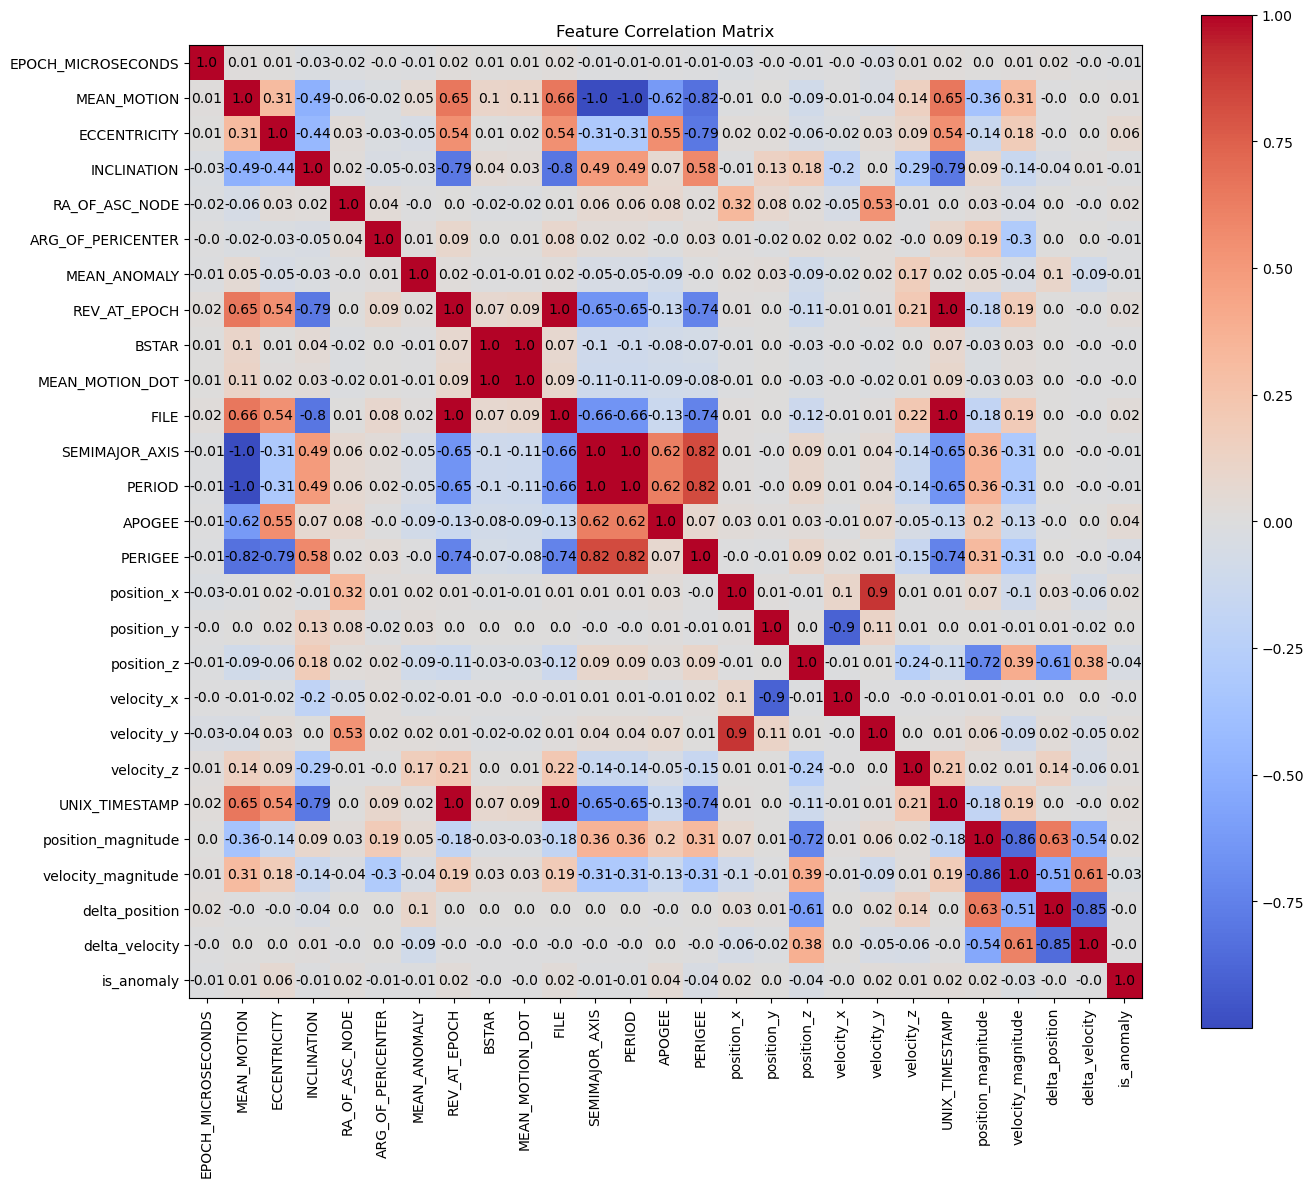

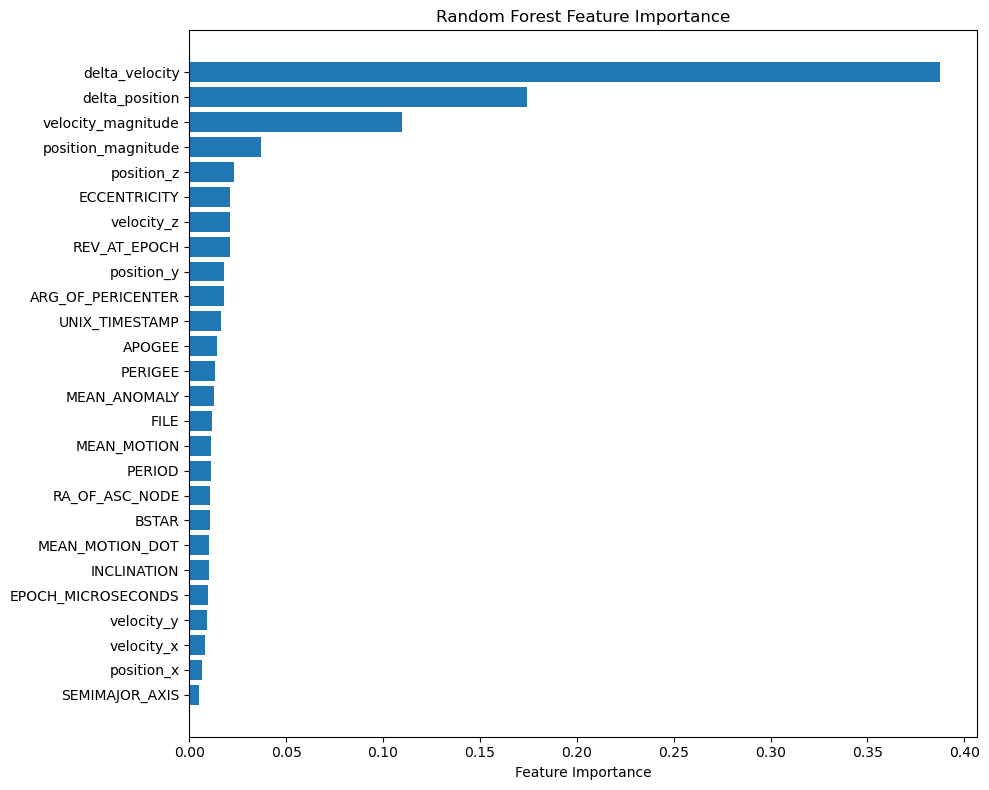

Selected 15 features for model training


In [18]:
def select_features(data):
    print("Selecting features for ML models...")
    
    #Correlation Matrix
    corr_matrix = data.corr()
    plt.figure(figsize=(14, 12))
    plt.imshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    for i in range(len(corr_matrix.index)):
        for j in range(len(corr_matrix.columns)):
            plt.text(j, i, round(corr_matrix.iloc[i, j], 2), ha="center", va="center", color="black")
    plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(np.arange(len(corr_matrix.index)), corr_matrix.index)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    #Random Forest Feature Importance
    feature_cols = data.select_dtypes(include=np.number).columns.difference(['is_anomaly'])
    X = data[feature_cols]
    y = data['is_anomaly']
    rf=RandomForestClassifier(n_estimators=200, random_state=42)#meaning of life
    rf.fit(X,y)
    feature_importance = rf.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = feature_importance[sorted_idx]
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()
    
    selected_features = [feature_cols[x] for x in sorted_idx[:15]]
    print(f"Selected {len(selected_features)} features for model training")
    X_selected = data[selected_features].values
    y=data['is_anomaly'].values
    
    return X_selected, y, selected_features
    

X,Y,selected_features = select_features(normed_data)

Now that we have selected our features, train test split